In [1]:
# Found at:
# https://medium.com/towards-data-science/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## The Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

In [3]:
data = pd.read_parquet('data/2_featured/tripfeatures.parquet')
data.columns = [col.lower().replace('_', ' ') for col in data.columns]
print(data.shape)
print(list(data.columns))

(5671033, 8)
['is subscriber', 'gender', 'tripduration in h', 'start dow', 'start hour', 'customer age', 'trip distance in km', 'trip speed kmh']


In [4]:
data.head()

,is subscriber,gender,tripduration in h,start dow,start hour,customer age,trip distance in km,trip speed kmh
0,Subscriber,Male,0.435000000000,Fr,11,47,5.638386,0.216030
1,Subscriber,Male,0.033333333333,Di,1,38,0.176047,0.088024
2,Subscriber,Male,0.031944450000,Di,1,38,0.176047,0.091851
3,Subscriber,Male,0.133055550000,Fr,18,57,1.400223,0.175393
4,Subscriber,Male,0.416111116667,Fr,8,43,4.683132,0.187575


### Create dummy variables

In [5]:
cat_vars=['gender', 'start dow', 'start hour']
for var in cat_vars:
    category_df = pd.get_dummies(data[var], prefix=var)
    category_df.columns = [col.lower().replace('_', ': ') for col in category_df]
    data = pd.concat([data,category_df] , axis=1)

# drop labeled categories
data = data.drop(cat_vars, axis=1)
    
# Remove base categories
data = data.drop('gender: male', axis=1) # set males as base category
data = data.drop('start dow: so', axis=1) # set sunday as base category
data = data.drop('start hour: 8', axis=1) # set eight as base category

In [6]:
data.head()

,is subscriber,tripduration in h,customer age,trip distance in km,trip speed kmh,gender: female,gender: unknown,start dow: di,start dow: do,start dow: fr,...,start hour: 14,start hour: 15,start hour: 16,start hour: 17,start hour: 18,start hour: 19,start hour: 20,start hour: 21,start hour: 22,start hour: 23
0,Subscriber,0.435000000000,47,5.638386,0.216030,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Subscriber,0.033333333333,38,0.176047,0.088024,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Subscriber,0.031944450000,38,0.176047,0.091851,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Subscriber,0.133055550000,57,1.400223,0.175393,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,Subscriber,0.416111116667,43,4.683132,0.187575,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Over-sampling using SMOTE

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# extract exogenous and endogenous variables
X = data.loc[:, data.columns != 'is subscriber']
y = data.loc[:, data.columns == 'is subscriber']

y = (y["is subscriber"] == 'Subscriber').astype(np.uint8)

# fix some dtypes for regression
X["tripduration in h"] = X["tripduration in h"].copy().astype('int64')
X["customer age"] = X["customer age"].copy().astype('int64')
X["trip distance in km"] = X["trip distance in km"].copy().astype('int64')


Xt, Xtt, yt, ytt = train_test_split(X, y, test_size = 0.25, random_state = 0)
yt, ytt = yt.astype('int'), ytt.astype('int')

os = SMOTE(random_state=0)
columns = Xt.columns

os_data_X,os_data_y=os.fit_resample(Xt, yt)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['is subscriber'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['is subscriber']==0]))
print("Number of subscription",len(os_data_y[os_data_y['is subscriber']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['is subscriber']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['is subscriber']==1])/len(os_data_X))

/var/folders/g1/nhrjlfln17gcld3sg2f59mk80000gn/T/ipykernel_32935/2294984075.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["tripduration in h"] = X["tripduration in h"].copy().astype('int64')
/var/folders/g1/nhrjlfln17gcld3sg2f59mk80000gn/T/ipykernel_32935/2294984075.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["customer age"] = X["customer age"].copy().astype('int64')
/var/folders/g1/nhrjlfln17gcld3sg2f59mk80000gn/T/ipykernel_32935/2294984075.py:13: SettingWithCopyWarning: 
A value is try

tripduration in h        int64
customer age             int64
trip distance in km      int64
trip speed kmh         float64
gender: female           uint8
gender: unknown          uint8
start dow: di            uint8
start dow: do            uint8
start dow: fr            uint8
start dow: mi            uint8
start dow: mo            uint8
start dow: sa            uint8
start hour: 0            uint8
start hour: 1            uint8
start hour: 2            uint8
start hour: 3            uint8
start hour: 4            uint8
start hour: 5            uint8
start hour: 6            uint8
start hour: 7            uint8
start hour: 9            uint8
start hour: 10           uint8
start hour: 11           uint8
start hour: 12           uint8
start hour: 13           uint8
start hour: 14           uint8
start hour: 15           uint8
start hour: 16           uint8
start hour: 17           uint8
start hour: 18           uint8
start hour: 19           uint8
start hour: 20           uint8
start ho

### Implementing the model

In [8]:
import statsmodels.api as sm
from copy import deepcopy

# add constants.
Xt = sm.add_constant(Xt)
Xtt = sm.add_constant(Xtt)

# copute logistic regression
logit_mod = sm.Logit(yt, Xt)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.122995
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          is subscriber   No. Observations:              4253274
Model:                          Logit   Df Residuals:                  4253238
Method:                           MLE   Df Model:                           35
Date:                Thu, 08 Sep 2022   Pseudo R-squ.:                  0.5915
Time:                        20:07:57   Log-Likelihood:            -5.2313e+05
converged:                       True   LL-Null:                   -1.2806e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.6187      0.021     29.586      0.000       0.578       0.660
tr

### Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix
yhat_prob = logit_res.predict(Xtt)
yhat = np.round(yhat_prob).astype(int)
confusion_matrix = confusion_matrix(ytt, yhat)
print(confusion_matrix)

[[  85651   40622]
 [  15215 1276271]]


In [16]:
from sklearn.metrics import classification_report
print(classification_report(ytt, yhat))

              precision    recall  f1-score   support

           0       0.85      0.68      0.75    126273
           1       0.97      0.99      0.98   1291486

    accuracy                           0.96   1417759
   macro avg       0.91      0.83      0.87   1417759
weighted avg       0.96      0.96      0.96   1417759



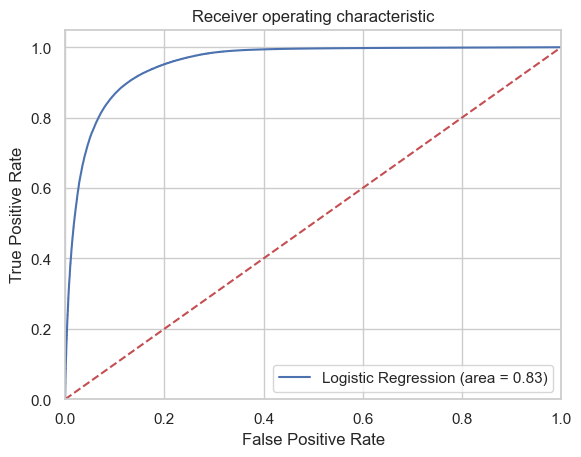

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(ytt, yhat)
fpr, tpr, thresholds = roc_curve(ytt, yhat_prob)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()